<a href="https://colab.research.google.com/github/hungryhunglee/project4/blob/main/ai03_%EC%9D%B4%EC%B0%AC_Section4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

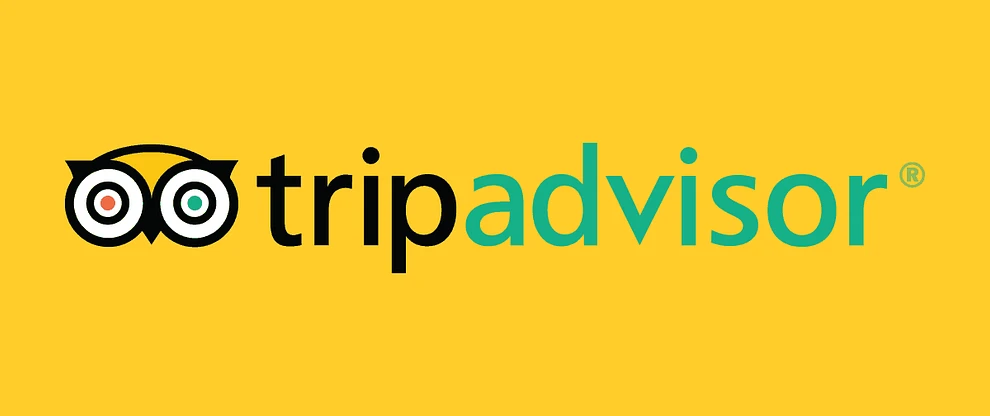

# **트립어드바이저 리뷰 데이터로 리뷰 예측모델 만들기**


In [1]:
# 라이브러리 불러오기

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords


import random as rn

import re
import urllib.request
import os

In [2]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 불러오기

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/Section_4/tripadvisor_hotel_reviews.csv')
data['Review'] = data['Review'].str.lower()
print("Data Shape: ", data.shape)
data.head()

Data Shape:  (20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
# 결측치 및 중복값 확인
print(data.isnull().sum())
print(data.duplicated().sum())

Review    0
Rating    0
dtype: int64
0


In [5]:
# 클래스 분포 시각화

class_dist = data['Rating'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y, marker_color='green')
    ])

    fig.update_layout(title_text=name)
    fig.show()

ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution')

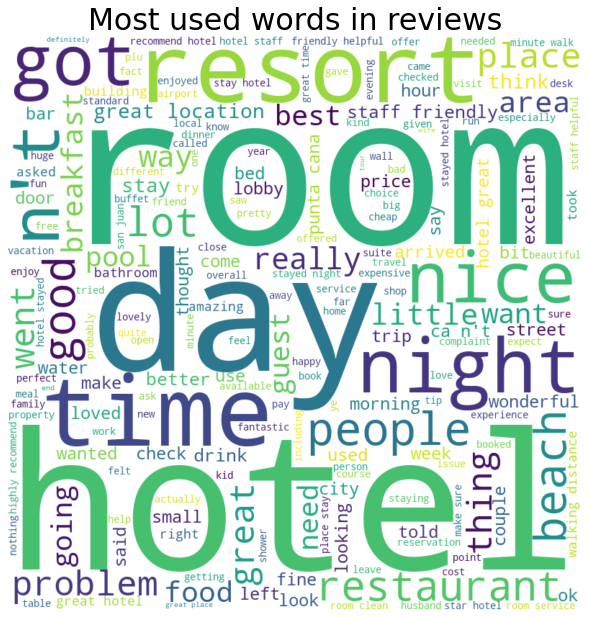

In [6]:
# 워드 클라우드로 빈번한 단어 시각화

def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))               
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

wordCloud_generator(data['Review'], title="Most used words in reviews")

In [7]:
# 데이터 전처리 시작

X = data['Review'].copy()
y = data['Rating'].copy()

In [8]:
# 숫자 및 불용어 제거

import nltk
nltk.download("stopwords")
nltk.download('punkt')

stop_words = stopwords.words('english')

def word_preprocessing(review):
    review = re.sub(r'\d+',' ', review)
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])

    return review


X_cleaned = X.apply(word_preprocessing)
X_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

In [9]:
# 토큰화 및 인덱스 확인

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

word_to_index = tokenizer.word_index
print(word_to_index)

{'hotel': 1, 'room': 2, 'great': 3, "n't": 4, 'good': 5, 'staff': 6, 'stay': 7, 'nice': 8, 'rooms': 9, 'location': 10, 'stayed': 11, 'service': 12, 'night': 13, 'time': 14, 'beach': 15, 'day': 16, 'breakfast': 17, 'clean': 18, 'food': 19, 'like': 20, 'resort': 21, 'place': 22, 'really': 23, 'the': 24, 'pool': 25, 'friendly': 26, 'people': 27, 'small': 28, 'little': 29, 'walk': 30, 'got': 31, 'excellent': 32, 'area': 33, 'best': 34, 'helpful': 35, 'bar': 36, 'restaurant': 37, 'restaurants': 38, 'bathroom': 39, 'water': 40, 'trip': 41, 'bed': 42, 'recommend': 43, 'view': 44, 'beautiful': 45, 'floor': 46, 'went': 47, 'comfortable': 48, 'desk': 49, 'nights': 50, 'check': 51, 'right': 52, 'want': 53, 'way': 54, 'free': 55, 'hotels': 56, 'better': 57, 'city': 58, 'away': 59, 'wonderful': 60, 'make': 61, 'ç': 62, 'booked': 63, 'price': 64, 'bit': 65, 'reviews': 66, 'large': 67, 'street': 68, 'minutes': 69, 'buffet': 70, 'say': 71, 'quite': 72, 'new': 73, 'days': 74, 'lobby': 75, 'experience':

In [10]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 24221
단어 집합(vocabulary)에서 희귀 단어의 비율: 48.896739679014836
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.166833430565438


In [12]:
# 등장 빈도가 1회인 단어들을 제외하는 재 토큰화

tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)


len_result = [len(x) for x in X]
vocab_size = len(tokenizer.word_index)
exp_sen = 1

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))
print("\n예시:\n")
print("기본 문장:\n{}".format(X_cleaned[exp_sen]))
print("\n토큰화 문장 :\n{}".format(X[exp_sen]))


# 패딩처리

X = pad_sequences(X, padding='post', maxlen=500)
print("\n패딩처리 문장 :\n{}".format(X[exp_sen]))

리뷰의 최대 길이 : 1914
리뷰의 평균 길이 : 100.12044312137036

예시:

기본 문장:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late night pm in

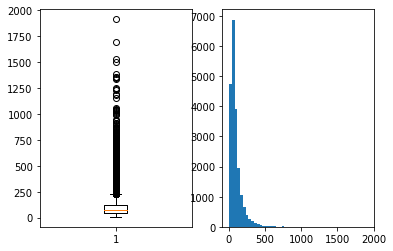

In [13]:
# 문장길이 시각화

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [14]:
# 인코딩

encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y = data['Rating'].copy()
y.replace(encoding, inplace=True)

In [15]:
# 데이터 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67, stratify=y)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14343, 500), (6148, 500), (14343,), (6148,))

In [17]:
# 랜덤씨드 생성

seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

In [18]:
# 하이퍼 파라미터 설정


EPOCHS = 3
BATCH_SIZE = 64
embedding_dim = 16
units = 76

In [19]:
# LSTM으로 딥러닝 모델 설정 및 학습 진행


model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['acc']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           792560    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 152)          56544     
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 64)           29248     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 15936)             0         
_________________________________________________________________
dropout (Dropout)            (None, 15936)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [20]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/3
180/180 [==============================] - 49s 248ms/step - loss: 1.2419 - acc: 0.4503 - val_loss: 0.9822 - val_acc: 0.5218
Epoch 2/3
180/180 [==============================] - 42s 234ms/step - loss: 0.9383 - acc: 0.5652 - val_loss: 0.9069 - val_acc: 0.5884
Epoch 3/3
180/180 [==============================] - 42s 232ms/step - loss: 0.7768 - acc: 0.6540 - val_loss: 0.8993 - val_acc: 0.5974


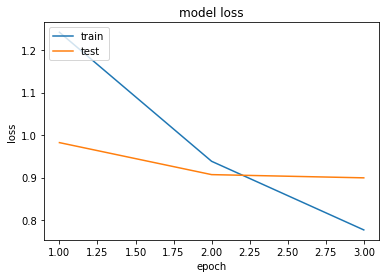

In [21]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Epoch 3회가 지나서부터는 val_loss와 val_accuracy가 오버피팅 되고 있어서 Epoch를 3으로 모델을 학습완료 시킴.

pred = np.argmax(model.predict(X_test), axis=-1)
print('최종 정확도: {}'.format(accuracy_score(pred, y_test)))

최종 정확도: 0.6115810019518543


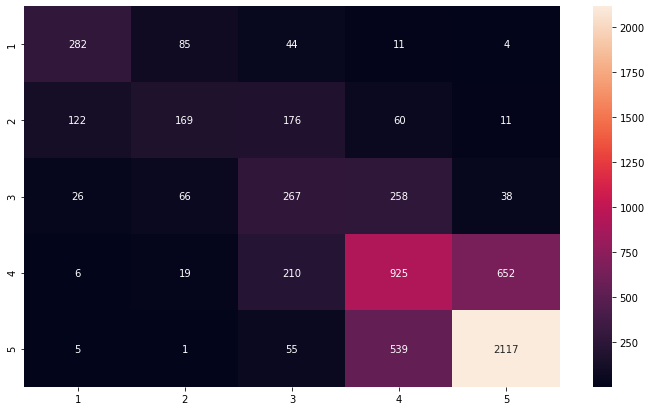

In [23]:
# Confusion Matrix를 통한 시각화

conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [24]:
# 위의 Confusion Matrix와 아래 분류리포트를 통해서 볼 수 있듯이 중간 리뷰의 정확도는 떨어지나 양극단의 리뷰는 그나마 정확도가 나은 편임.

print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

           1       0.64      0.66      0.65       426
           2       0.50      0.31      0.38       538
           3       0.36      0.41      0.38       655
           4       0.52      0.51      0.51      1812
           5       0.75      0.78      0.76      2717

    accuracy                           0.61      6148
   macro avg       0.55      0.53      0.54      6148
weighted avg       0.61      0.61      0.61      6148

